In [33]:
import pyLDAvis.gensim
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import gensim
import nltk
import json
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gensim import corpora, models
from itertools import chain

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

#### Preprocessing Functions

In [34]:
# Since with the cleaned data we got poor results for the topics, let's try choosing only meaningfull words with pos_tags
def clean_up(s):
    words = re.findall('[^\d\W]+', str(s))
    words = [w.lower() for w in words if not w.startswith('http://') and len(w)>2]
    return words
 
def stopwords(s):
    stop = pd.read_csv('stop_topics.txt', sep=' ')['stopwords'].to_list()
    return [word for word in s if word not in stop]

# tagging and stemming
def tag_stem(l):
    # importing trainned tagger (for portuguese)
    f = open('tagger.pickle', 'rb')
    tagger = pickle.load(f)
    f.close()
    tagged = tagger.tag(l)
    return [nltk.RSLPStemmer().stem(w) for w,t in tagged if t == 'NOUN']

def set_up(s):
    s = clean_up(s)
    s = stopwords(s)
    return tag_stem(s)

#### Setting up Data

In [4]:
with open('labelled.json') as json_data:
    data = json.load(json_data)
    
df = pd.DataFrame.from_dict(data)

# pre processing
processed = df['words'].apply(set_up)

In [5]:
with open("tag_stems_topics.json", "w") as f:
    json.dump(processed.to_dict(), f)

In [11]:
# building dictionaries and corpus count for lda
dic = gensim.corpora.Dictionary(processed)
dic.filter_extremes(no_below=10, no_above=0.2)
corpus = [dic.doc2bow(text) for text in processed]

#### Applying LDA model for Topics

In [12]:
# looping to find best results

topics = range(2,20)

for i in topics:
    lda = LdaMulticore(corpus, id2word=dic, num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda, texts=processed, dictionary=dic)
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score:', (i, coherence_lda))


Coherence Score: (2, 0.23957725253251194)

Coherence Score: (3, 0.23680554915915705)

Coherence Score: (4, 0.2694043558465226)

Coherence Score: (5, 0.24944296491080467)

Coherence Score: (6, 0.2620840790343973)

Coherence Score: (7, 0.24680948320722362)

Coherence Score: (8, 0.28467831576959035)

Coherence Score: (9, 0.25142311833098957)

Coherence Score: (10, 0.2681100328538415)

Coherence Score: (11, 0.2637000024366988)

Coherence Score: (12, 0.25178297345715367)

Coherence Score: (13, 0.2869351847049758)

Coherence Score: (14, 0.27687850281101234)

Coherence Score: (15, 0.27344608277639015)

Coherence Score: (16, 0.28905857550477165)

Coherence Score: (17, 0.28458834005468875)

Coherence Score: (18, 0.28226063620897285)

Coherence Score: (19, 0.2863962983480794)


In [13]:
lda = LdaMulticore(corpus, id2word=dic, num_topics=8)

In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dic)

C:\Users\Evelien\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [15]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.043802 -0.000248       1        1  17.804285
1     -0.018367  0.006634       2        1  13.973943
0      0.001297  0.007437       3        1  13.709820
6     -0.009255 -0.020219       4        1  13.162933
3      0.000097  0.016038       5        1  12.272150
7     -0.010674 -0.000565       6        1  10.605978
5     -0.009696  0.003704       7        1  10.302525
4      0.002797 -0.012781       8        1   8.168368, topic_info=    Category         Freq   Term        Total  loglift  logprob
378  Default  5341.000000    dan  5341.000000  30.0000  30.0000
751  Default  3933.000000  segur  3933.000000  29.0000  29.0000
184  Default  2696.000000   préd  2696.000000  28.0000  28.0000
845  Default  1887.000000   acid  1887.000000  27.0000  27.0000
137  Default  2799.000000   praz  2799.000000  26.0000  26.0000
..       ...          ...    ...          ...      ...      ...
147   Topic8   225.796204    tod  2608.546631   0.0580  -5.7174
130   Topic8   225.682602     le  2652.524658   0.0408  -5.7180
135   Topic8   233.057312    ped  3178.996582  -0.1081  -5.6858
405   Topic8   198.059158  contr  2097.859375   0.1448  -5.8485
144   Topic8   196.058914   serv  2091.915039   0.1375  -5.8587

[638 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
689       1  0.210512  abastec
689       2  0.157884  abastec
689       3  0.105256  abastec
689       4  0.052628  abastec
689       5  0.105256  abastec
...     ...       ...      ...
833       4  0.350120     óbit
833       5  0.087530     óbit
833       6  0.087530     óbit
833       7  0.043765     óbit
833       8  0.087530     óbit

[3598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 7, 4, 8, 6, 5])

##### PROBABLE TOPICS:
1. Responsabilidade Civil / Acidentes / Seguros
2. Direito Comercial / Compra e Venda
3. Direito das Obrigações / Imóveis
4. Direito Processual
5. Direito das Obrigações / Execuções / Seguros
6. Direito das Obrigações / Imóveis
7. Direito das Obrigações / Insolvência
8. Direito Bancário

In [19]:
# Evaluating topic distribution

coherence_model_lda = CoherenceModel(model=lda, texts=processed, dictionary=dic)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3060580051515792


#### Applying KMeans model for Topics

In [26]:
#First vectorizing with weights
vec = TfidfVectorizer()
vec.fit_transform(np.array(processed.apply(' '.join).to_list()))
vec_dic_w = dict(zip(vec.get_feature_names(), vec.idf_))

X = np.array(processed.apply(lambda x: [v if k in x else 0 for k,v in vec_dic_w.items()]).to_list())
pca = PCA(n_components=2).fit_transform(X)

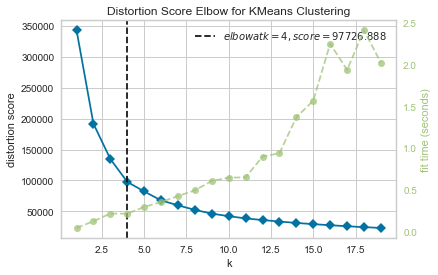

In [27]:
# Finding the best cluster number
visualizer = KElbowVisualizer(KMeans(), k=(1,20))
visualizer.fit(pca)
visualizer.poof()

In [28]:
# Training model with lda cluster numbers
model_k = KMeans(n_clusters=6)
model_k.fit(pca)
df['topic'] = model_k.labels_

In [29]:
# testing kmeans with elbow number of clusters
model_k_best = KMeans(n_clusters=visualizer.elbow_value_)
model_k_best.fit(pca)
df['subtopics'] = model_k_best.labels_

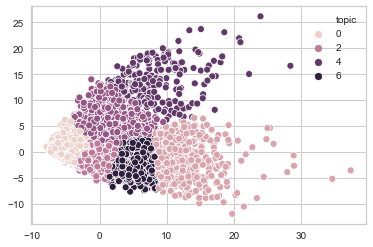

In [30]:
sns.scatterplot(pca[:, 0], pca[:, 1], hue=df['topic'])

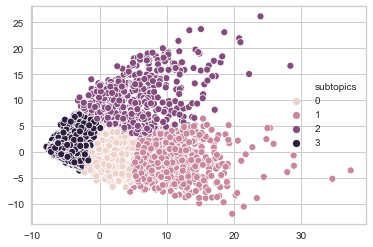

In [31]:
sns.scatterplot(pca[:, 0], pca[:, 1], hue=df['subtopics'])

#### Applying LDA to document
Since LDA seems to make more sense in the category distribution, let's apply it to the dataset.

In [129]:
# extracting labels from lda
labels = []
for tuples in lda[corpus]:
    lst = []
    tuples = sorted(tuples, key=lambda x: x[1], reverse=True)
    for i,j in tuples:
        if j > coherence_lda:
            lst += [i]
        else:
            lst += ['']
    labels += [lst]
        
df['labels'] = labels

In [135]:
df['labels'] = df['labels'].apply(lambda x: [i for i in x if type(i) == int])